# Store the running state avg, variance first then random mask training

In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file_random_mask import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
np.random.seed(0)
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")

In [2]:
class adversial_env(object):
    def __init__(self,runst=True):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.max_turn = 1000
        self.combine_ratio = 0.05
        self.mask = np.random.choice([1],size = [1,5])
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.run_st = runst
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r 
        
        self.total_score += final_r
        
        if self.epi_num%300 == 299:
            self.mask = np.random.choice([1],size = [1,5])
            self.mask[0,np.random.randint(0,4, size=1)[0]] = 0 
        
        if self.run_st:
            self.obser_noise = self.obsr
        else:        
            self.obser_noise = (self.obsr*self.mask)[0]
        
        
        return self.obser_noise, final_r, done, 0
    
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.mask = np.random.choice([1],size = [1,5])
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[1:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('total reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.show()

# performance in adversarial env without observer

In [3]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        obs, r, done, _ = env.step(obs)
        if done:
            do = True

        score += r

[2018-04-02 03:36:39,446] Making new env: RoboschoolInvertedPendulum-v1


549.0 [549.0] [550]


In [4]:
env.result_plot()

# define an observer (new agent)

In [5]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env()
agn = agent(env, args)
agn.learn()

[2018-04-02 03:38:10,906] Making new env: RoboschoolInvertedPendulum-v1


9.0 [9.0] [10]
Episode 0	Last reward: 25.0	Average reward 21.71
('lagrange multiplier:', 0.9923650629296963, 'grad_norm:', 0.13349826878631363)
fval before 9.073191975546469e-15
a/e/r 0.019714733042859933 0.01984730125859399 0.9933205923562703
fval after -0.01971473304285086
Episode 1	Last reward: 32.0	Average reward 28.02
('lagrange multiplier:', 1.4509394784375336, 'grad_norm:', 0.1966062621152415)
fval before 2.662012876764366e-16
a/e/r 0.032989173810011596 0.02901878956874717 1.1368211527864853
fval after -0.03298917381001133
Episode 2	Last reward: 146.0	Average reward 39.71
('lagrange multiplier:', 1.4488292370317368, 'grad_norm:', 0.2180566880945316)
fval before 1.4722067005053134e-15
a/e/r 0.03188090145659181 0.028976584740635202 1.1002297800776966
fval after -0.03188090145659034
Episode 3	Last reward: 47.0	Average reward 64.40
('lagrange multiplier:', 1.4364674177542023, 'grad_norm:', 0.23856782041711883)
fval before 2.056360883913923e-15
a/e/r 0.029779174783010988 0.0287293483

In [6]:
agn.save_model('agent_model/random_period_mask_observer')

In [7]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 25000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 930
        
args = par()
env = adversial_env(runst=False)
agn = agent(env, args)
agn.load_model('agent_model/random_period_mask_observer')

[2018-04-02 03:47:17,959] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [8]:
agn.learn(run_state_update = False)

629.0 [629.0] [630]
Episode 0	Last reward: 1000.0	Average reward 625.76
('lagrange multiplier:', 0.26814830252617616, 'grad_norm:', 0.04899987598972682)
fval before 3.849604001818441e-17
a/e/r 0.0053436431489128034 0.005362966050519488 0.9963969748410373
fval after -0.005343643148912765
Episode 1	Last reward: 903.0	Average reward 617.71
('lagrange multiplier:', 0.3974362891657896, 'grad_norm:', 0.061164663719744855)
fval before -4.700795719378706e-16
a/e/r 0.008034915826881676 0.007948725741782474 1.0108432581396216
fval after -0.008034915826882146
Episode 2	Last reward: 1000.0	Average reward 776.39
('lagrange multiplier:', 0.3454322723170059, 'grad_norm:', 0.055270717510816206)
fval before 6.491907913713066e-16
a/e/r 0.006933588667906582 0.006908645478708181 1.0036104312017853
fval after -0.006933588667905933
Episode 3	Last reward: 1000.0	Average reward 758.59
('lagrange multiplier:', 0.22665334893474953, 'grad_norm:', 0.03396295474021375)
fval before 5.936800541109708e-17
a/e/r 0.004

Episode 31	Last reward: 767.0	Average reward 719.97
('lagrange multiplier:', 0.3560978073027091, 'grad_norm:', 0.06359634400279061)
fval before 1.7342195601133145e-16
a/e/r 0.00713501978342213 0.007121956049722349 1.0018342901316122
fval after -0.007135019783421957
Episode 32	Last reward: 1000.0	Average reward 695.65
('lagrange multiplier:', 0.29588842572971885, 'grad_norm:', 0.0485417811960001)
fval before 5.2140238244177674e-17
a/e/r 0.005961290667082425 0.005917767719632284 1.0073546224711984
fval after -0.005961290667082373
Episode 33	Last reward: 1000.0	Average reward 764.45
('lagrange multiplier:', 0.3690070458225201, 'grad_norm:', 0.17269643928641995)
fval before -9.115913760207573e-16
a/e/r 0.007143057266245574 0.0073801554228121865 0.9678735550969918
fval after -0.007143057266246485
Episode 34	Last reward: 1000.0	Average reward 805.59
('lagrange multiplier:', 0.2790503303810477, 'grad_norm:', 0.07213346077813029)
fval before 8.255073872537724e-17
a/e/r 0.0056829037171231365 0.

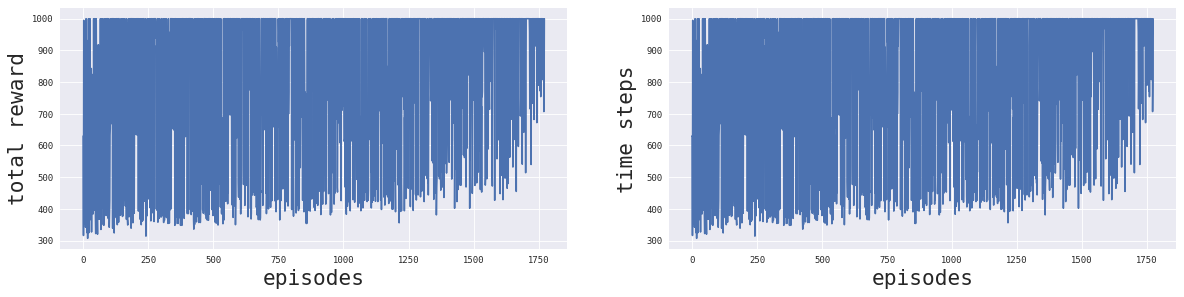

In [9]:
env.result_plot()

# Agent evaluation

In [10]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-04-02 04:12:14,693] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


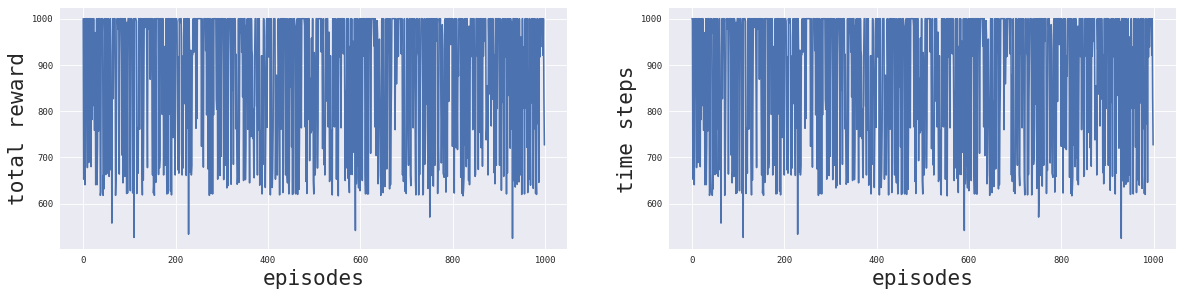

In [11]:
env.result_plot()

# Performance on non_adversarial environment with observer

In [12]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

[2018-04-02 04:19:19,437] Making new env: RoboschoolInvertedPendulum-v1


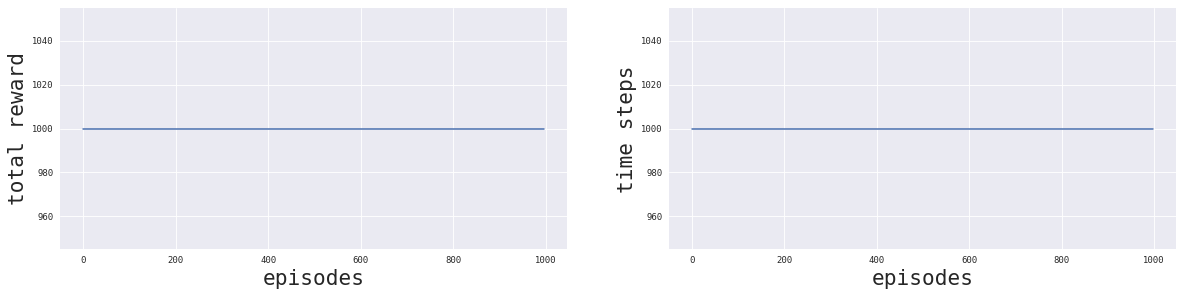

In [13]:
env.result_plot()

# Save model

In [14]:
agn.save_model('agent_model/random_period_mask_observer')